## Exploratory data analysis of the TACO dataset


#### Section 1: Explore image size

#### Section 2: Distribution of the annotations

#### Section 3: Visualization of the images

In [1]:
import os
import numpy as np
import pandas as pd
import json

from PIL import Image
import cv2
import skimage
import albumentations as A

import matplotlib.pyplot as plt
import seaborn as sns

import random

image_dir = './data/all_images'
labels_dir = './data/splits/labels.csv'
sup_labels_dir = './data/splits/sup_cat_labels.csv'

### Section 1: Image size

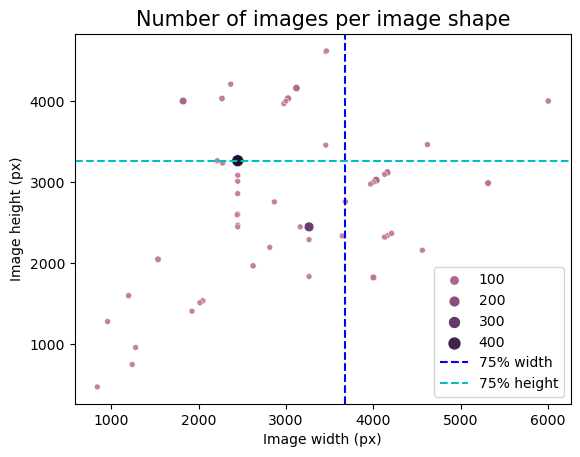

In [6]:


# As the files come from different sources, they have different sizes
widths = []
heights = []
shape_freqs = []
img_shapes_keys = {}



for filename in os.listdir(image_dir):
    if filename.endswith('.jpg'):
        with Image.open(os.path.join(image_dir, filename)) as img:
            key = str(img.size[0]) + '-' + str(img.size[1])
            if key in img_shapes_keys:
                shape_id = img_shapes_keys[key]
                shape_freqs[shape_id] += 1
            else:
                img_shapes_keys[key] = len(widths)
                widths.append(img.size[0])
                heights.append(img.size[1])
                shape_freqs.append(1)


d = {'Image width (px)': widths, 'Image height (px)': heights, '# images': shape_freqs}
df = pd.DataFrame(d)

p75_width = np.percentile(widths, 75)
p75_height = np.percentile(heights, 75)


cmap = sns.cubehelix_palette(dark=.1, light=.6, as_cmap=True)
plot = sns.scatterplot(x="Image width (px)", y="Image height (px)", size='# images', hue="# images", palette=cmap, data=df)
plot = plot.set_title('Number of images per image shape', fontsize=15)

plot = plt.axvline(p75_width, color='b', linestyle='--', label='75% width')
plot = plt.axhline(p75_height, color='c', linestyle='--', label='75% height')
plot= plt.legend()


### Section 2: Distribution of the annotations

The mean amount of annotations is: 2.05


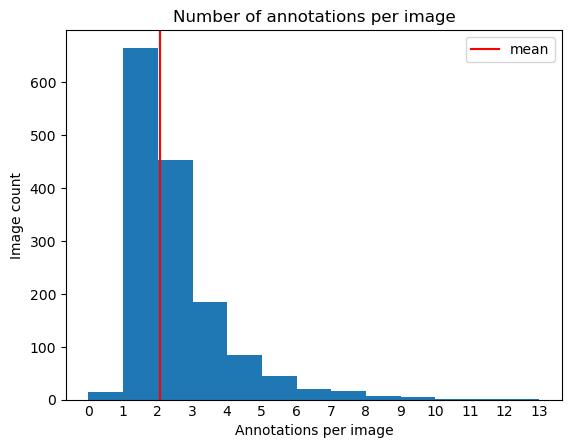

In [20]:
# Annotations per image
labels = pd.read_csv(labels_dir)
sup_labels = pd.read_csv(sup_labels_dir)
labels['sum_annot'] = labels.iloc[:,1:].sum(axis = 1)

plt.hist(labels['sum_annot'], bins = 13);
plt.title('Number of annotations per image')
plt.xticks(np.arange(min(labels['sum_annot']), max(labels['sum_annot'])+1, 1.0))
plt.tick_params(axis='x', which='both', length=0)
plt.axvline(x=(round(np.mean(labels["sum_annot"]),2)), color='red', label='mean')
plt.xlabel('Annotations per image')
plt.ylabel('Image count')
plt.legend()

print( f'The mean amount of annotations is: {round(np.mean(labels["sum_annot"]),2)}')


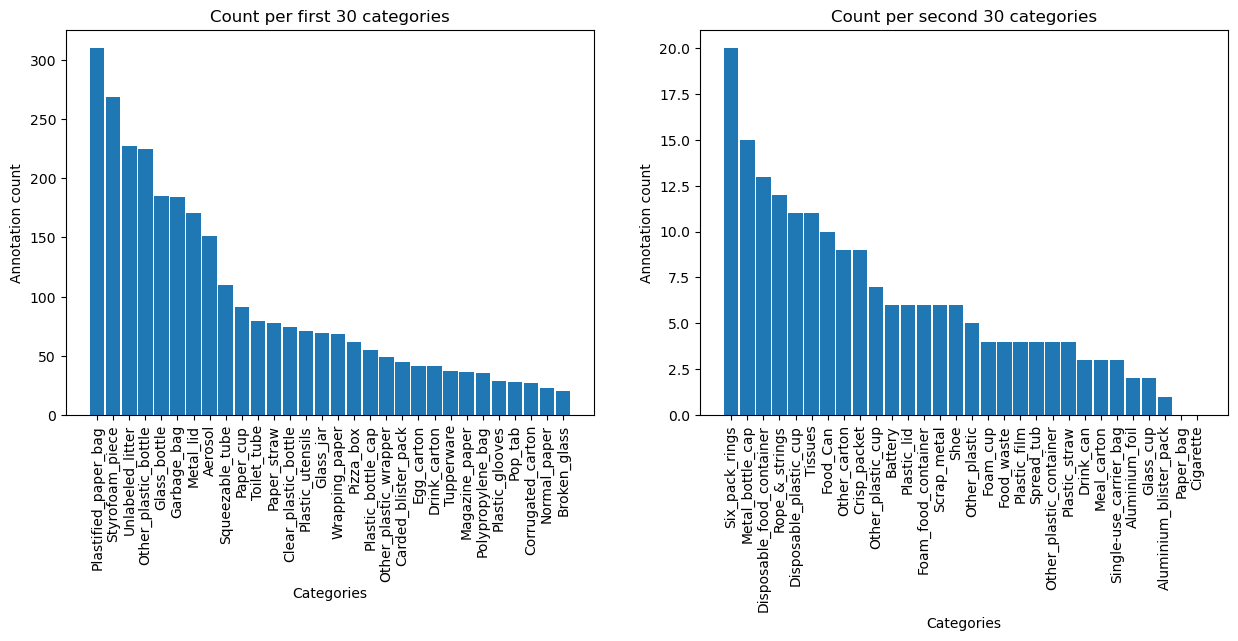

In [22]:
#Count per categories, all categories
count_labels = labels.iloc[:,1:-1].sum().to_dict()
count_labels = dict(sorted(count_labels.items(), key=lambda item: item[1], reverse=True))

labels_name = list(count_labels.keys())
labels_count = list(count_labels.values())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.bar(labels_name[:-int((len(labels_name)/2))], labels_count[:-int((len(labels_name)/2))],width=0.9)
ax1.set_xlabel('Categories')
ax1.set_ylabel('Annotation count')
ax1.set_title(f'Count per first {int(len(labels_name)/2)} categories')
ax1.set_xticks(range(int(len(labels_name)/2)))
ax1.set_xticklabels(labels_name[:-int((len(labels_name)/2))],rotation = 90)

ax2.bar(labels_name[int((len(labels_name)/2)):], labels_count[int((len(labels_name)/2)):],width=0.9)
ax2.set_xlabel('Categories')
ax2.set_ylabel('Annotation count')
ax2.set_title(f'Count per second {int(len(labels_name)/2)} categories')
ax2.set_xticks(range(int(len(labels_name)/2)))
ax2.set_xticklabels(labels_name[int((len(labels_name)/2)):],rotation = 90)

plt.subplots_adjust(wspace=0.2)

plt.show()

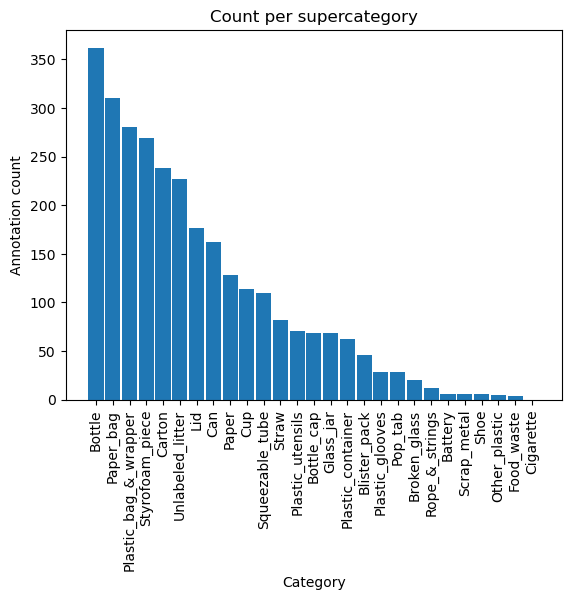

In [23]:
#Count per Supercategories
sup_labels

count_s_labels = sup_labels.iloc[:,1:-1].sum().to_dict()
count_s_labels = dict(sorted(count_s_labels.items(), key=lambda item: item[1], reverse=True))

s_labels = list(count_s_labels.keys())
s_labels_count = list(count_s_labels.values())

plt.bar(s_labels, s_labels_count ,width=0.9)
plt.xticks(rotation = 90)
plt.title('Count per supercategory')
plt.xlabel('Category')
plt.ylabel('Annotation count')
plt.show()

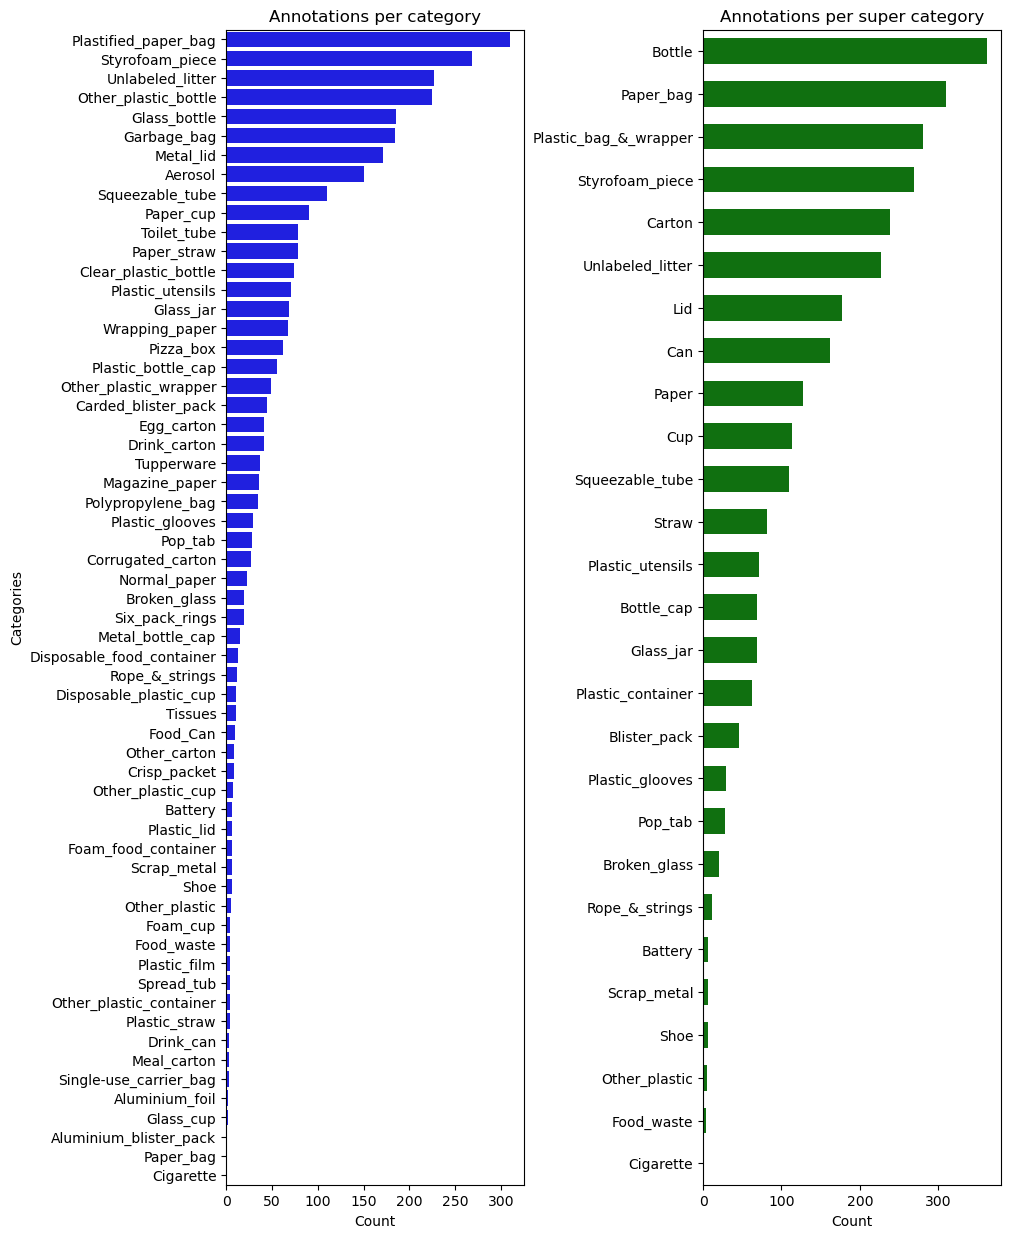

In [45]:

f, ax = plt.subplots(1, 2, figsize=(10, 15)) 

sns.barplot(x=labels_count, y=labels, label="Total", color="b",
            width=0.8, linewidth=5, ax=ax[0])  


ax[0].set_title("Annotations per category")
ax[0].set_xlabel("Count")
ax[0].set_ylabel("Categories")

sns.barplot(x=s_labels_count, y=s_labels, label="Total", color="g",
            width=0.6, linewidth=15, ax=ax[1]) 


ax[1].set_title("Annotations per super category")
ax[1].set_xlabel("Count")
#ax[1].set_ylabel("Categories")

plt.subplots_adjust(wspace=0.6)


plt.show()


### Section 3: Visualization of the images

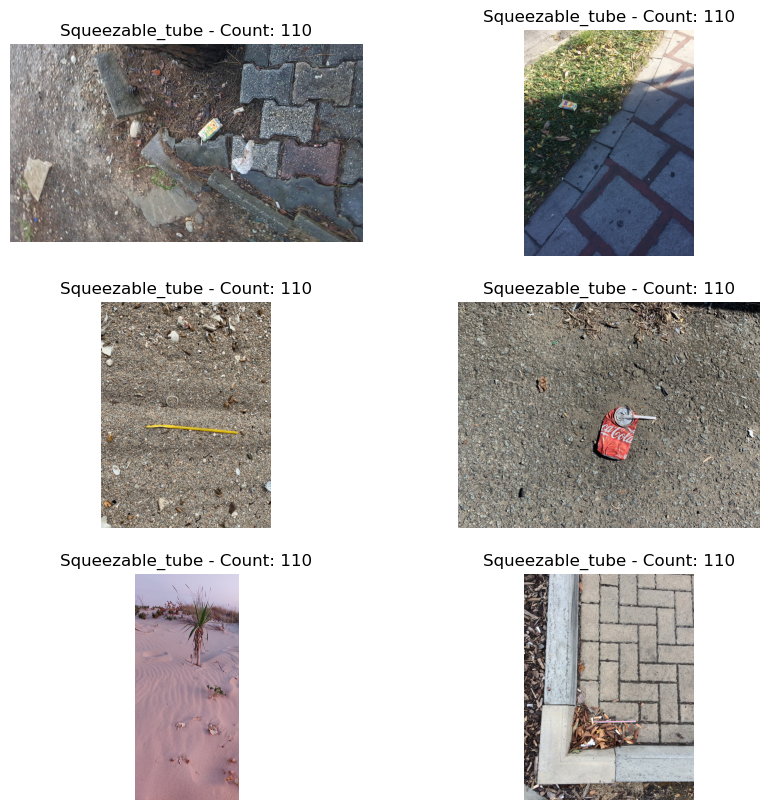

In [25]:
labels = pd.read_csv(labels_dir)
sup_labels = pd.read_csv(sup_labels_dir)

def show_images_for_category(df, column_name, image_size = 10, folder_path = './data/all_images'):
    """
    Function to show 4 images where the value of the specified column is 1.

    Args:
        column_name (str): Name of the column to filter by.
    """
    
    
    filtered_df = df[df[column_name] == 1]
    filenames = filtered_df['file_name'].tolist()

    if len(filenames) >= 6:
        filenames = random.sample(filenames, 6)

    fig, axs = plt.subplots(3, 2, figsize=(image_size, image_size))
    axs = axs.flatten()

    for i, filename in enumerate(filenames):
        image_path = os.path.join(folder_path, filename)
        image = Image.open(image_path)
        title = f'{column_name} - Count: {len(filtered_df)}' 
        
        axs[i].set_title(title)
        axs[i].imshow(image)
        axs[i].axis('off')

    plt.show()
    
show_images_for_category(labels,'Squeezable_tube')

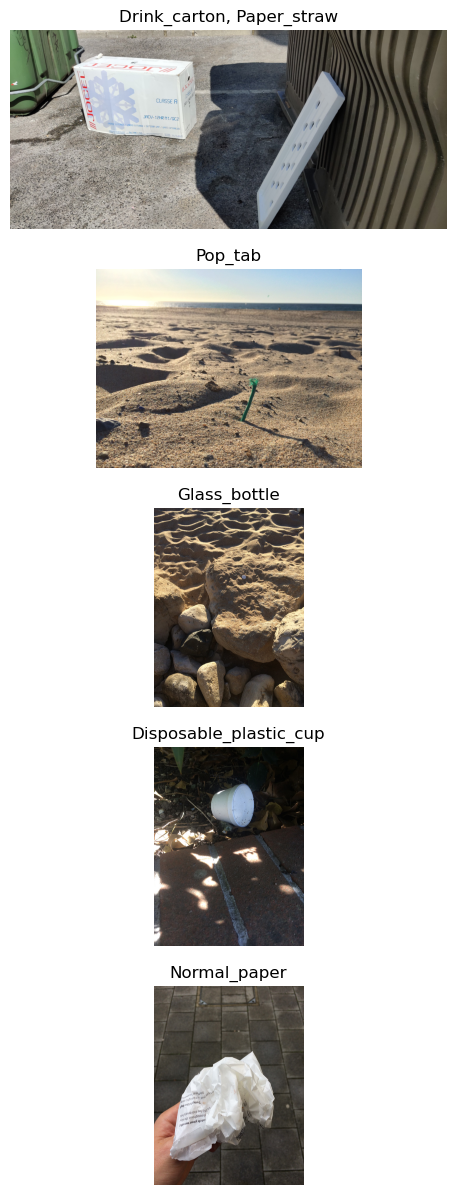

In [66]:
# Show 5 random images with all their annotations 

labels_dir = './data/labels.csv'
sup_labels_dir = './data/sup_cat_labels.csv'
df_labels = pd.read_csv(labels_dir)
df_sup_labels = pd.read_csv(sup_labels_dir)

folder_path = './data/all_images'



def show_img(df = df_labels, folder_path = './data/all_images'):
    
    filenames = df_labels['file_name'].tolist()

    fig, axs = plt.subplots(5, 1, figsize=(10, 15))
    selected_filenames = random.sample(filenames, 5)


    for i, filename in enumerate(selected_filenames):
        image_path = os.path.join(folder_path, filename)
        image = Image.open(image_path)
        
        row = df[df['file_name'] == filename].iloc[0]
        columns_with_1 = row[row == 1].index.tolist()
        title = ', '.join(columns_with_1)
        axs[i].set_title(title)

        axs[i].imshow(image)
        axs[i].axis('off')

    plt.show()
        
show_img(filenames)

### Section 4: Visualize image augmentations

In [2]:
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.metrics import structural_similarity as ssim


with open('./config.json', 'r') as f:
    config = json.loads(f.read())

image_dir = config['img_dir']
img_size = config['img_size']
batch_size = config['batch_size'] 

learning_rate = 0.0001
patience = 5
epochs = 2

train_df = pd.read_csv(config['train_metadata_filepath'])
val_df = pd.read_csv(config['val_metadata_filepath'])
test_df = pd.read_csv('./data/splits/test_material_2023-04-13.csv')

seed = config['seed']
labels = list(train_df.columns)[1:]

Found 1053 validated image filenames.


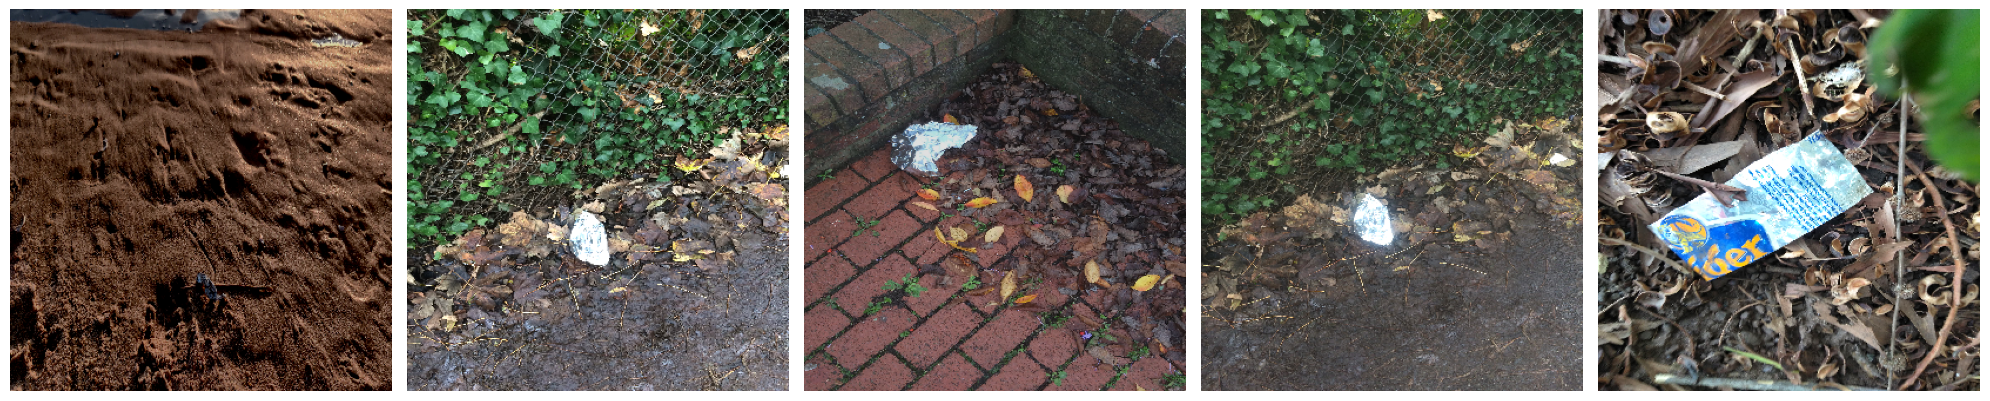

In [65]:
augmentation_pipeline = A.Compose([
        #A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),
        #A.GridDistortion (num_steps=5, distort_limit=0.6, interpolation=1, border_mode=4, value=None, mask_value=None, normalized=False, p = 0.6),
        #A.HorizontalFlip(p = 0.5),
        #A.VerticalFlip(p = 0.5),
        #A.ToGray(p=0.01),
        #A.GaussNoise (var_limit=(0.0024, 0.012), mean=0, per_channel=True, always_apply=False, p = 0.5),
        #A.Rotate(limit=350, p = 0.5),
        #A.Transpose(p = 0.4),
        #A.PixelDropout (dropout_prob=0.01, per_channel=True, drop_value=0, p=0.4),
        #A.HueSaturationValue (hue_shift_limit=1, sat_shift_limit=1.1, val_shift_limit=0.1, p = 0.2),
        #A.ChannelShuffle(p=0.3)
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1)
    ])

def augment_images(images):
    images = images.astype(np.float32) / 255.0
    augmented_image = augmentation_pipeline(image=images)['image']
    diff_temp = calc_diff(images,augmented_image)
    my_list.append(diff_temp)
    return augmented_image


datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=augment_images
    )

train_generator = datagen_train.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='file_name',
    y_col=labels,
    class_mode='raw',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=False
    )

def plotImages(images_arr):
    """This function will plot images in the form of a grid with 1 row and 5 columns 
    where images are placed in each column."""
    
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    return

sample_training_images, _ = next(train_generator)
plotImages(sample_training_images)

#### Find augmentation parameters

Use a while loop to find suitable variables for an adequate information loss.
SSIM is used as a measure, 1 = images are equal, -1 = images totally different. A 
SSIM = 0.8 translates to an information loss of 10 %.

In [63]:


info_loss = {}
info_loss['GaussN_loss_10perc']=[]
my_list = info_loss['GaussN_loss_10perc']


def mse(orig, augm):

	err = np.sum((orig.astype("float") - augm.astype("float")) ** 2)
	err /= float(orig.shape[0] * orig.shape[1])
	return err

def calc_diff(orig, augm):
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
    augm = cv2.cvtColor(augm, cv2.COLOR_BGR2GRAY)
	#m = mse(orig, augm)
    s = ssim(orig, augm, data_range=1.0)
    return s

dist = 0.1

mean = 0.6
while mean < 0.8:

    list_loss = []

    augmentation_pipeline = A.Compose([
        # Add your desired augmentations here
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),
        A.GridDistortion (num_steps=5, distort_limit=0.6, interpolation=1, border_mode=4, value=None, mask_value=None, normalized=False, p = 0.6),
        A.HorizontalFlip(p = 0.5),
        A.VerticalFlip(p = 0.5),
        A.ToGray(p=0.01),
        A.GaussNoise (var_limit=(0.0024, 0.012), mean=0, per_channel=True, always_apply=False, p = 0.5),
        A.Rotate(limit=350, p = 0.5),
        A.Transpose(p = 0.4),
        A.PixelDropout (dropout_prob=0.01, per_channel=True, drop_value=0, p=0.4),
        A.HueSaturationValue (hue_shift_limit=1, sat_shift_limit=1.1, val_shift_limit=0.1, p = 0.2),
        A.ChannelShuffle(p=0.3)
    ])

    def augment_images(images):
        images = images.astype(np.float32) / 255.0
        augmented_image = augmentation_pipeline(image=images)['image']
        diff_temp = calc_diff(images,augmented_image)
        my_list.append(diff_temp)
        return augmented_image


    datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=augment_images
    )

    train_generator = datagen_train.flow_from_dataframe(
        dataframe=train_df,
        directory=image_dir,
        x_col='file_name',
        y_col=labels,
        class_mode='raw',
        target_size=(img_size, img_size),
        batch_size=batch_size,
        shuffle=False
    )
    
    for i in range(3):
        sample_training_images, _ = next(train_generator)
        
    list_loss = info_loss['GaussN_loss_10perc']

    mean = sum(list_loss) / len(list_loss)
    
    #print(f'SSIM: {round(mean,2)} - var lower {var_min} & var higher {var_max} ')
    var_max = var_max - 0.002
    var_min = var_max/5
    
    dist = dist + 0.1
    
    print(f'SSIM: {round(mean,2)}')
    
    if var_min < 1e-4:
        var_min = 1e-4



Found 1053 validated image filenames.
SSIM: 0.05
Found 1053 validated image filenames.
SSIM: 0.08
Found 1053 validated image filenames.
SSIM: 0.09
Found 1053 validated image filenames.
SSIM: 0.08
Found 1053 validated image filenames.
SSIM: 0.09
Found 1053 validated image filenames.
SSIM: 0.09
Found 1053 validated image filenames.
SSIM: 0.09
Found 1053 validated image filenames.
SSIM: 0.08
Found 1053 validated image filenames.
SSIM: 0.08
Found 1053 validated image filenames.
SSIM: 0.09
Found 1053 validated image filenames.
SSIM: 0.09
Found 1053 validated image filenames.
SSIM: 0.09
Found 1053 validated image filenames.


KeyboardInterrupt: 

In [35]:
def plotImages(images_arr):
    """This function will plot images in the form of a grid with 1 row and 5 columns 
    where images are placed in each column."""
    
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    return


for i in range(5):
    sample_training_images, _ = next(train_generator)
    #plotImages(sample_training_images)

KeyError: 'GaussN_var10_50'

420